In [2]:
import os
import math
import torch
import csv
import time
import operator

from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from matplotlib.path import Path
from random import randint

import cv2 as cv
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec



In [3]:
# create the environment
# ------------------
# filled with obstacles
# ------------------
# Define different shapes:
#
def create_polygon(x, y, lmin, lmax, n):
    '''
    creating a quadrangle in a image
    (x_0, y_0) : coordinate of center of polygon
    (x1, y1), ..., (x4, y4) : coordinate of each vertices 
    '''
    x_0, y_0 = np.random.uniform(0,x), np.random.uniform(0, y)
    
    # randomly choose the angle for each vertice
    theta = np.zeros(n)
    for i in range(n):
        theta[i] = np.random.uniform(2*np.pi*i/n, 2*np.pi*(i+1)/n)
    
    # randomly choose the length for each vertice
    length = np.zeros(n)
    for i in range(n):
        length[i] = np.random.uniform(lmin, lmax)
    
    # compute the coordinate of 4 vertice
    vertices = np.zeros((n,2))
    for i in range(n):
        vertices[i][0] = x_0 + length[i] * np.cos(theta[i])
        vertices[i][1] = y_0 + length[i] * np.sin(theta[i])
    return vertices

def create_circle(x, y, rmin, rmax):
    center = np.zeros(2)
    center[0], center[1] = np.random.uniform(0, x), np.random.uniform(0, y)
    radius = np.random.uniform(rmin, rmax)
    return center, radius

def check_polygon(img, vertices):
    x, y = img.shape[0], img.shape[1] 
    p = Path(vertices)
    for i in range(x):
        for j in range(y):
            img[i][j] = (img[i][j] or (p.contains_points([(i, j)]) == True))
    return img

def check_circle(img, center, radius):
    x, y = img.shape[0], img.shape[1]
    for i in range(x):
        for j in range(y):
            img[i][j] = (img[i][j] or (np.sqrt((center[0] - i)*(center[0] - i) + (center[1] - j)*(center[1] - j)) <= radius))
    return img

def add_obstacle(img, lmin, lmax, rmin, rmax, n_min, n_max, rate=0.2):
    x, y = img.shape[0], img.shape[1]
    n = randint(n_min, n_max)
    for i in range(n):
        flag = np.random.uniform(0,1)
        if flag <= rate:
            center, radius = create_circle(x, y, rmin, rmax)
            img = check_circle(img, center, radius)
        else:
            vertices = create_polygon(x, y, lmin, lmax, randint(3,6))
            img = check_polygon(img, vertices)  
    return img

def create_graph_path(img, N, K, w_min, w_max):
    points = np.zeros((N, 2))
    x, y = img.shape[0], img.shape[1]
    print(x, y)
    # make the start and goal on the left down corner
    # and right top corner
    points[0][0], points[0][1] = randint(0, 10), randint(0, 10)
    points[1][0], points[1][1] = randint(x - 10, x), randint(y - 10, y)
    for i in range(2,N):
        points[i][0], points[i][1] = randint(0, x), randint(0, y)
    
    # Create K-nn Graph
    edge = []
    for i in range(N):
        distances = []
        for j in range(N):
            if i == j:
                continue
            dist = (points[i][0] - points[j][0])*(points[i][0] - points[j][0])+\
            (points[i][1] - points[j][1])*(points[i][1] - points[j][1])
            distances.append((dist, j))
        distances.sort(key = operator.itemgetter(0))
        
        for k in range(K):
            if i * N + distances[k][1] in edge:
                continue
            edge.append(i * N + distances[k][1])
            
            # distances[k][0] : distance between point i and j
            # distances[k][1] : j
            x_s, y_s = points[i][0].astype(int), points[i][1].astype(int)
            x_g, y_g = points[distances[k][1]][0].astype(int), points[distances[k][1]][1].astype(int)
            thickness = randint(w_min, w_max)
            cv.line(img, (y_s, x_s), (y_g, x_g), (255, 255, 255), thickness)
            
            
            
            '''
            slope = (y_g - y_s)/(x_g - x_s + 0.001)
            min_x = min(x_s.astype(int), x_g.astype(int))
            max_x = max(x_s.astype(int), x_g.astype(int))
            for x_t in range(min_x, max_x):
                y_t = (y_s + (slope * (x_t - min_x))).astype(int)
                for w in range(width):
                    y_new = y_t + w
                    x_new = x_t + w
                    if x_new >= 0 and x_new < x and y_new >= 0 and y_new < y:
                        img[x_new][y_new] = 1
                    
                    y_new = y_t + w
                    x_new = x_t - w
                    if x_new >= 0 and x_new < x and y_new >= 0 and y_new < y:
                        img[x_new][y_new] = 1
                    
                    y_new = y_t - w
                    x_new = x_t + w
                    if x_new >= 0 and x_new < x and y_new >= 0 and y_new < y:
                        img[x_new][y_new] = 1
                    
                    y_new = y_t - w
                    x_new = x_t - w
                    if x_new >= 0 and x_new < x and y_new >= 0 and y_new < y:
                        img[x_new][y_new] = 1
            '''
    return img



In [532]:
x = 128
y = 128
img = np.zeros((x,y))
for i in range(10):
    img = create_graph_path(img, 10, 5, 3, 5)
    np.save("/home/zhizuo/lego/landmark/data/path_128_128_{}.npz".format(i), img)

x = 128
y = 256
img = np.zeros((x,y))
for i in range(10):
    img = create_graph_path(img, randint(13,17), 5, 4, 6)
    np.save("/home/zhizuo/lego/landmark/data/path_128_256_{}.npz".format(i), img)

x = 256
y = 256
img = np.zeros((x,y))
for i in range(10):
    img = create_graph_path(img, randint(14,18), 5, 6, 8)
    np.save("/home/zhizuo/lego/landmark/data/path_256_256_{}.npz".format(i), img)
    


128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 256
128 256
128 256
128 256
128 256
128 256
128 256
128 256
128 256
128 256
256 256
256 256
256 256
256 256
256 256
256 256
256 256
256 256
256 256
256 256


In [4]:
x, y = 128, 128
for i in range(10):
    img = np.zeros((x,y))
    img = add_obstacle(img, x//20, y//10, x//20, y//10, 30, 40, rate = 0.2)
    np.save("/home/zhizuo/lego/landmark/data/polygon_128_128_{}.npz".format(i), img)

x, y = 128, 256
for i in range(10):
    img = np.zeros((x,y))
    img = add_obstacle(img, x//20, y//10, x//20, y//10, 30, 40, rate = 0.2)
    np.save("/home/zhizuo/lego/landmark/data/polygon_128_256_{}.npz".format(i), img)
    
x, y = 256, 256
for i in range(10):
    img = np.zeros((x,y))
    img = add_obstacle(img, x//20, y//10, x//20, y//10, 30, 40, rate = 0.2)
    np.save("/home/zhizuo/lego/landmark/data/polygon_256_256_{}.npz".format(i), img)
    
    

128 128


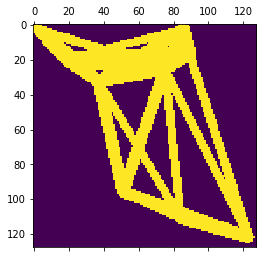

In [15]:
x = 128
y = 128
img = np.zeros((x,y))
img = create_graph_path(img, 10, 4, 4, 5)
plt.matshow(img)
plt.show()

256 256


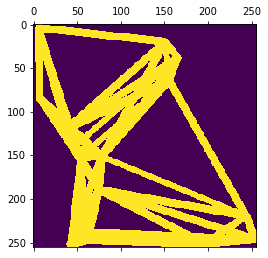

In [7]:
x = 256
y = 256
img = np.zeros((x,y))
img = create_graph_path(img, randint(14,18), 5, 6, 8)
plt.matshow(img)
plt.show()

128 128


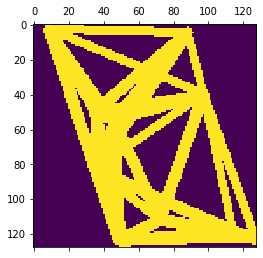

In [531]:
x = 128
y = 128
img = np.zeros((x,y))
img = create_graph_path(img, 10, 5, 3, 5)
plt.matshow(img)
plt.show()

In [1]:
x = 256
y = 256
img = np.zeros((x,y))

img = add_obstacle(img, x//20, y//10, x//20, y//10, 30, 40, rate=0.2)
plt.matshow(img)
plt.show()

NameError: name 'np' is not defined

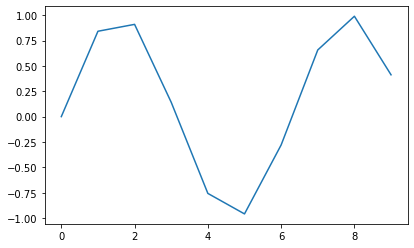

In [429]:
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
x = np.arange(10)
y = np.sin(x)
cs = CubicSpline(x, y)
xs = np.arange(-0.5, 9.6, 0.1)
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(x, cs(x))